In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data = pd.read_csv('/home/felipe.castanogonzal/data/principal_data.csv')
data

,PrincipalDetails,IsDuplicated,BloomFilter32Bit
0,aabar3031973,1,1643689933
1,aaliyahottens14121918,0,3567187259
2,aaliyahottens14121918,1,3567187259
3,aarobbstovm1931973,1,48879422
4,aaronbarsoum3031973,1,2877932438
...,...,...,...
15986,zoewastell15121998,0,539910774
15987,zoewastell15121998,1,539910774
15988,zoewebb17121910,0,3715518538
15989,zoewebb17121910,1,3715518538


## Feature Engineering

Convert to Binary Representation:

using format(x, '032b')

In [3]:
data['BloomFilter32Bit_Binary'] = data['BloomFilter32Bit'].apply(lambda x: f"{x:032b}")

Count the 1s in the binary representation:

In [4]:
data['BF_CountOf1s'] = data['BloomFilter32Bit_Binary'].apply(lambda x: x.count('1'))

Compute Length of the Bloom Filter:

The length is constant (32 bits for this case) but it's to calculate the density

In [5]:
data['BF_Length'] = data['BloomFilter32Bit_Binary'].apply(len)

Compute the density of 1s (proportion of 1s in the binary string):

In [6]:
data['BF_Density'] = data['BF_CountOf1s'] / data['BF_Length']

Pairwise Similarity - Calculate pairwise Hamming distances:

In [ ]:
data['Hamming_Similarity'] = data['BloomFilter32Bit_Binary'].apply(
    lambda x: 1 - hamming(
        [int(c) for c in x], 
        [int(c) for c in data['BloomFilter32Bit_Binary'][0]]  # Compare with first row
    )
)

In [14]:
# Convert 'BloomFilter32Bit_Binary' into separate binary features
bloom_filter_columns = data['BloomFilter32Bit_Binary'].apply(lambda x: pd.Series(list(map(int, x))))
bloom_filter_columns.columns = [f'bit_{i}' for i in range(bloom_filter_columns.shape[1])]

# Drop the original binary column and combine with the main dataframe
data = pd.concat([data.drop(columns=['BloomFilter32Bit_Binary']), bloom_filter_columns], axis=1)

In [15]:
data

,PrincipalDetails,IsDuplicated,BloomFilter32Bit,BF_CountOf1s,BF_Length,BF_Density,Hamming_Similarity,bit_0,bit_1,bit_2,...,bit_22,bit_23,bit_24,bit_25,bit_26,bit_27,bit_28,bit_29,bit_30,bit_31
0,aabar3031973,1,1643689933,19,32,0.59375,1.00000,0,1,1,...,1,1,1,1,0,0,1,1,0,1
1,aaliyahottens14121918,0,3567187259,20,32,0.62500,0.46875,1,1,0,...,0,1,0,0,1,1,1,0,1,1
2,aaliyahottens14121918,1,3567187259,20,32,0.62500,0.46875,1,1,0,...,0,1,0,0,1,1,1,0,1,1
3,aarobbstovm1931973,1,48879422,17,32,0.53125,0.56250,0,0,0,...,1,1,0,0,1,1,1,1,1,0
4,aaronbarsoum3031973,1,2877932438,16,32,0.50000,0.46875,1,0,1,...,1,1,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15986,zoewastell15121998,0,539910774,13,32,0.40625,0.43750,0,0,1,...,1,0,0,1,1,1,0,1,1,0
15987,zoewastell15121998,1,539910774,13,32,0.40625,0.43750,0,0,1,...,1,0,0,1,1,1,0,1,1,0
15988,zoewebb17121910,0,3715518538,16,32,0.50000,0.40625,1,1,0,...,0,0,0,1,0,0,1,0,1,0
15989,zoewebb17121910,1,3715518538,16,32,0.50000,0.40625,1,1,0,...,0,0,0,1,0,0,1,0,1,0


**Define X and y for the model**

In [16]:
# Prepare the data
X = data.drop(columns=['IsDuplicated','PrincipalDetails','BF_Length'])  # Drop 'IsDuplicated' to use all other columns as input features
y = data['IsDuplicated']  # Target variable

In [17]:
X

,BloomFilter32Bit,BF_CountOf1s,BF_Density,Hamming_Similarity,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,...,bit_22,bit_23,bit_24,bit_25,bit_26,bit_27,bit_28,bit_29,bit_30,bit_31
0,1643689933,19,0.59375,1.00000,0,1,1,0,0,0,...,1,1,1,1,0,0,1,1,0,1
1,3567187259,20,0.62500,0.46875,1,1,0,1,0,1,...,0,1,0,0,1,1,1,0,1,1
2,3567187259,20,0.62500,0.46875,1,1,0,1,0,1,...,0,1,0,0,1,1,1,0,1,1
3,48879422,17,0.53125,0.56250,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
4,2877932438,16,0.50000,0.46875,1,0,1,0,1,0,...,1,1,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15986,539910774,13,0.40625,0.43750,0,0,1,0,0,0,...,1,0,0,1,1,1,0,1,1,0
15987,539910774,13,0.40625,0.43750,0,0,1,0,0,0,...,1,0,0,1,1,1,0,1,1,0
15988,3715518538,16,0.50000,0.40625,1,1,0,1,1,1,...,0,0,0,1,0,0,1,0,1,0
15989,3715518538,16,0.50000,0.40625,1,1,0,1,1,1,...,0,0,0,1,0,0,1,0,1,0


In [18]:
y

0        1
1        0
2        1
3        1
4        1
        ..
15986    0
15987    1
15988    0
15989    1
15990    1
Name: IsDuplicated, Length: 15991, dtype: int64

## Over sampling for unbalanced data with `imblearn`

In [19]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [20]:
# Split the resampled data into training and testing sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42)

## Classification Model

In [21]:
# Train the XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1]), random_state=42)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test_res)

# Evaluate the model
print(classification_report(y_test_res, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      0.63      0.70      3585
           1       0.68      0.84      0.75      3345

    accuracy                           0.73      6930
   macro avg       0.74      0.73      0.73      6930
weighted avg       0.74      0.73      0.73      6930



In [23]:
# Generate the classification report as a dictionary
classification_rep_XGB = classification_report(y_test_res, y_pred_xgb, output_dict=True)

# Convert the dictionary to a DataFrame
report_df = pd.DataFrame(classification_rep_XGB).transpose()

# Display the DataFrame
report_df

,precision,recall,f1-score,support
0,0.804006,0.627057,0.704592,3585.000000
1,0.676584,0.836173,0.747961,3345.000000
accuracy,0.727994,0.727994,0.727994,0.727994
macro avg,0.740295,0.731615,0.726276,6930.000000
weighted avg,0.742502,0.727994,0.725525,6930.000000


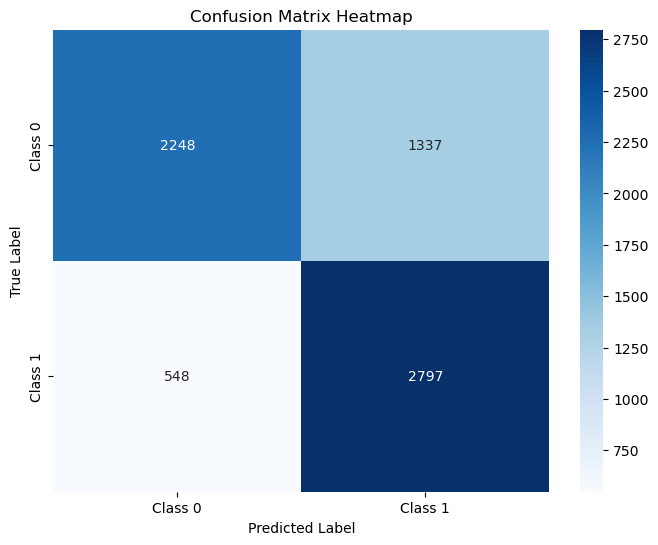

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_res, y_pred_xgb)

# Plot the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()